In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time

from matplotlib import pyplot as plt

from assembly_gym.envs.assembly_env import AssemblyEnv, Shape, Block
from assembly_gym.envs.gym_env import AssemblyGym, sparse_reward, tower_setup, bridge_setup, hard_tower_setup, Action

from assembly_gym.utils import align_frames_2d
from assembly_gym.utils.rendering import plot_assembly_env, render_assembly_env, plot_block_movements

pybullet build time: Nov 28 2023 23:48:36


# The Assembly Environment

The assembly environment is a wrapper around the pybullet physics engine. It provides a simple interface to add blocks and obstacles to the environment.

The basic element is defined by `Shape` which loads the geometry from a urdf file. The `Shape` class provides an interface to compute relative coordinates for each of the faces or edges in 2d.
A `Block` is defined by a `Shape` and a position and orientation in 3d space.

In [2]:
# load shapes
trapezoid = Shape(urdf_file='shapes/trapezoid.urdf')
vblock = Shape(urdf_file='shapes/v_block.urdf')
cube = Shape(urdf_file='shapes/cube.urdf')
cube = Shape(urdf_file='shapes/small_cube.urdf')
tblock = Shape(urdf_file='shapes/t_block.urdf')

trapezoid.num_faces_2d, trapezoid.urdf_file

(4,
 '/mydata/robotoddler/johannes/robotoddler-dev/assembly_gym/assembly_gym/../shapes/trapezoid.urdf')

In [3]:
env = AssemblyEnv(render=False)

argv[0]=


## add one block and visualize the contact points


{'last_block': Block (1), 'stable': True, 'initial_state': [((0.35, 0.0, 0.021650634706020355), Quaternion(1.000, 0.000, 0.000, 0.000))], 'final_state': [((0.3500000000000328, -7.54318251579253e-14, 0.022640634708338242), Quaternion(1.000, 0.000, 0.000, 0.000))], 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': -1}


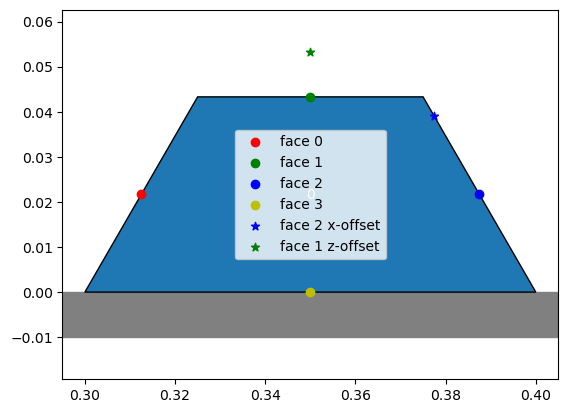

In [4]:
env.reset()
shape = trapezoid

# place first block on floor
position, rotation = align_frames_2d(env.get_floor_frame(), shape.get_face_frame_2d(face=3), frame1_coordinates=[0.35, 0, 0])

block1 = Block(shape=shape, position=position, orientation=rotation.quaternion)
print(env.add_block(block1))
fig, ax = plot_assembly_env(env)


colors = ['r', 'g', 'b', 'y']
# plot contact point for all faces
for i in range(4):
    frame = block1.get_face_frame_2d(face=i)
    contact_point = frame.to_world_coordinates([0.0, 0, 0])
    ax.scatter([contact_point[0]], [contact_point[2]], label=f'face {i}', color=colors[i])

# shift the contact point  in frame coordinates
frame = block1.get_face_frame_2d(face=2)
contact_point = frame.to_world_coordinates([-0.02, 0, 0])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 2 x-offset', color=colors[2])

frame = block1.get_face_frame_2d(face=1)
contact_point = frame.to_world_coordinates([0.0, 0, 0.01])
ax.scatter([contact_point[0]], [contact_point[2]], marker='*', label=f'face 1 z-offset', color=colors[1])

ax.legend()
env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

In [5]:
env.blocks

[Block (1)]

1
{'last_block': Block (1), 'stable': True, 'initial_state': [((0.35, 0.0, 0.021650634706020355), Quaternion(1.000, 0.000, 0.000, 0.000))], 'final_state': [((0.3500000000000328, -7.54318251579253e-14, 0.022640634708338242), Quaternion(1.000, 0.000, 0.000, 0.000))], 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': -1, 'frozen': 0}


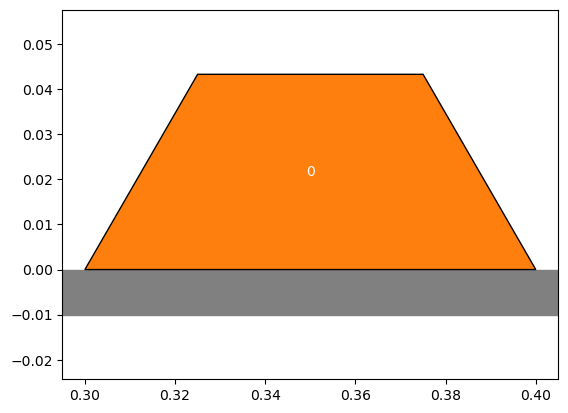

In [6]:
print(env.freeze_block(len(env.blocks)-1))
plot_assembly_env(env)
print(env.state_info)

{'last_block': Block (1), 'stable': True, 'initial_state': [((0.35, 0.0, 0.021650634706020355), Quaternion(1.000, 0.000, 0.000, 0.000))], 'final_state': [((0.3500000000000328, -7.54318251579253e-14, 0.022640634708338242), Quaternion(1.000, 0.000, 0.000, 0.000))], 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': -1, 'frozen': -1}


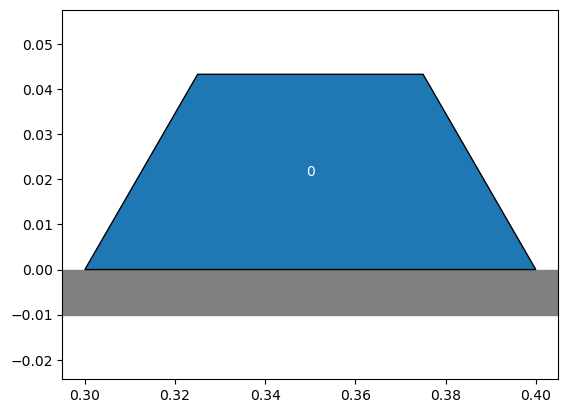

In [7]:
env.unfreeze_block()
plot_assembly_env(env)
print(env.state_info)

# next, we are adding two obstacles and two more blocks

{'last_block': Block (1), 'stable': True, 'initial_state': [((0.35, 0.0, 0.021650634706020355), Quaternion(1.000, 0.000, 0.000, 0.000)), ((0.3887500007413413, -2.296212839189421e-18, 0.07577722227118272), Quaternion(0.500, 0.000, 0.866, 0.000))], 'final_state': [((0.3500014143598099, 5.286782249092044e-06, 0.02263796399714058), Quaternion(1.000, -0.000, 0.000, 0.000)), ((0.38874067732499185, 1.2775859546292629e-05, 0.07876923105903506), Quaternion(0.500, -0.000, 0.866, 0.000))], 'collision': False, 'collision_info': {'obstacles': [], 'blocks': [], 'floor': False, 'bounding_box': False}, 'frozen_block': -1}
{'last_block': Block (4), 'stable': True, 'initial_state': [((0.35, 0.0, 0.021650634706020355), Quaternion(1.000, 0.000, 0.000, 0.000)), ((0.3887500007413413, -2.296212839189421e-18, 0.07577722227118272), Quaternion(0.500, 0.000, 0.866, 0.000)), ((0.42624999960633797, -5.684344357516736e-18, 0.03247595099221518), Quaternion(0.500, -0.000, -0.866, -0.000))], 'final_state': [((0.349952

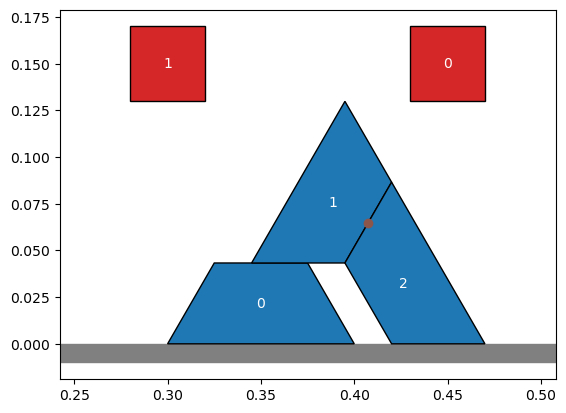

In [8]:
# add obstacles (shift them to create a collision)
env.add_obstacle(Block(shape=cube, position=[0.45, 0.0, .15]))
env.add_obstacle(Block(shape=cube, position=[0.3, 0.0, .15]))

# add second block
position, rotation = align_frames_2d(block1.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.02, 0.0, 0])
block2 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block2))


# add third block
#contact point of block 2 (just for plotting):
p2 = block2.get_face_frame_2d(1).to_world_coordinates([-0.0, 0, 0])
position, rotation = align_frames_2d(block2.get_face_frame_2d(face=1), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[-0.0, 0.0, 0])
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(2), frame1_coordinates=[0.2, 0.0, 0])
block3 = Block(shape=trapezoid, position=position, orientation=rotation.quaternion)
print(env.add_block(block3))

# # add another block on the floor, in a collision position
# position, rotation = align_frames_2d(env.get_floor_frame(), trapezoid.get_face_frame_2d(face=2), frame1_coordinates=[0.45, 0.0, -0.01])
# block4 = Block(base_block=trapezoid, position=position, orientation=rotation.quaternion)
# print(env.add_block(block4))

fig, ax = plot_assembly_env(env)
ax.scatter([p2[0]], [p2[2]])

In [9]:
# simulate the environment

env.restore()
time.sleep(1)
env.restore()
start_time = time.time()
max_time = 3
while True:
    env.realtime()
    if time.time() - start_time > max_time:
        break

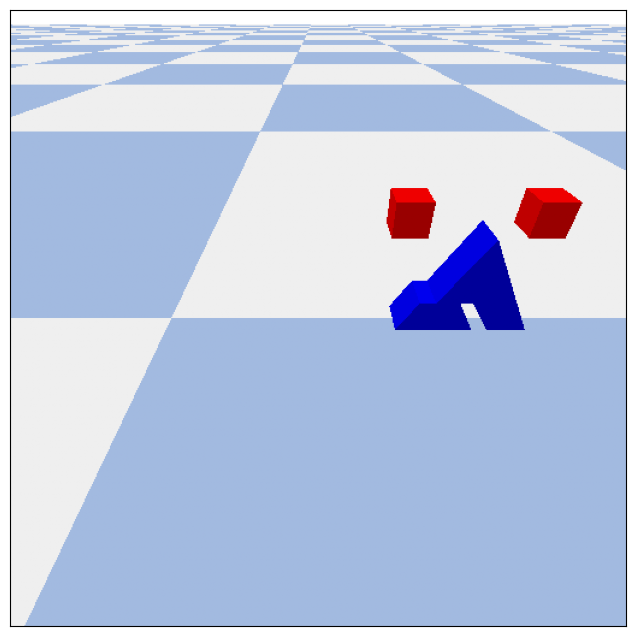

In [10]:
# render 3d view
fig, ax = render_assembly_env(near=0.001, fov=80, far=10, target=[0.2, 0, 0])

In [11]:
#  disconnect
env.disconnect_client()

# 2 AssemblyGym

The `AssemblyGym` class is a gym environment based on the `AssemblyEnv`.
It is defined by a set of available shapes, a set of obstacles, a set of targets, and a reward function.

## Tower setup

argv[0]=


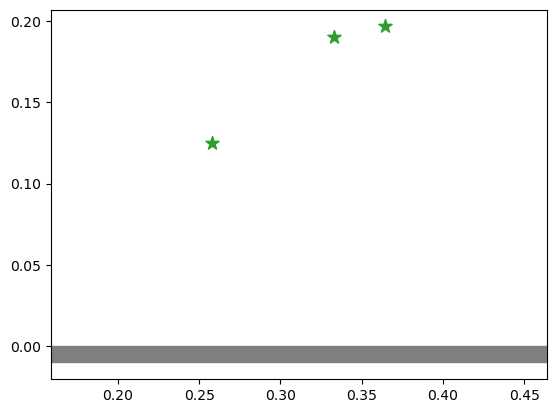

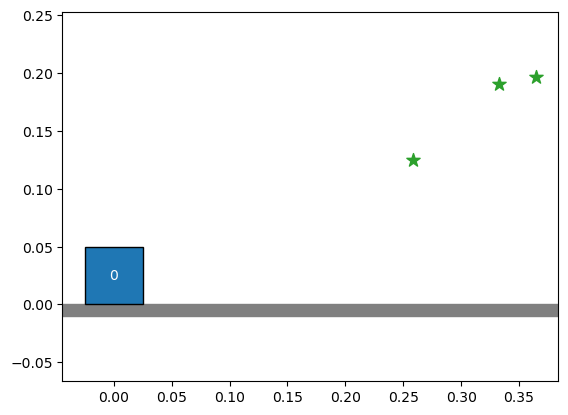

In [14]:
env = AssemblyGym(**tower_setup(), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False))
plot_assembly_env(env)

action = Action(-1, 1,0,0, 0, 0)

obs, _, _, _, info = env.step(action)
plot_assembly_env(env)

env.assembly_env.disconnect_client()

## Bridge Setup

argv[0]=


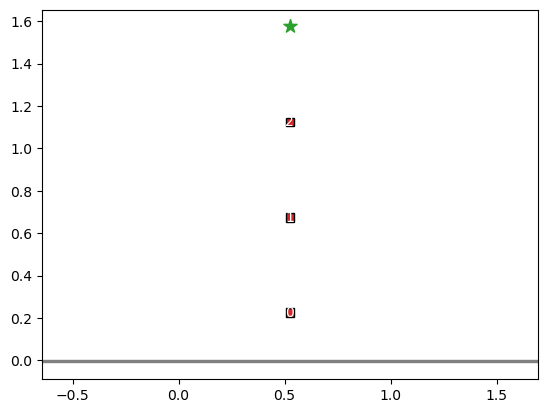

In [15]:
env = AssemblyGym(**bridge_setup(num_stories=3), 
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

## Bridge Demonstration

Stable: 1, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: 1, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: 1, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: False, Truncated: None
--------------------------------------------------
Stable: 0, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: True, Truncated: None
--------------------------------------------------
Stable: 0, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: True, Truncated: None
--------------------------------------------------
Stable: 0, Frozen Block: -1, Collision: 0, Targets Reached: 0
Reward: -1, Terminated: True, Truncated: None
--------------------------------------------------
Stable: 0, Frozen Block: -1, Collision: 0, 

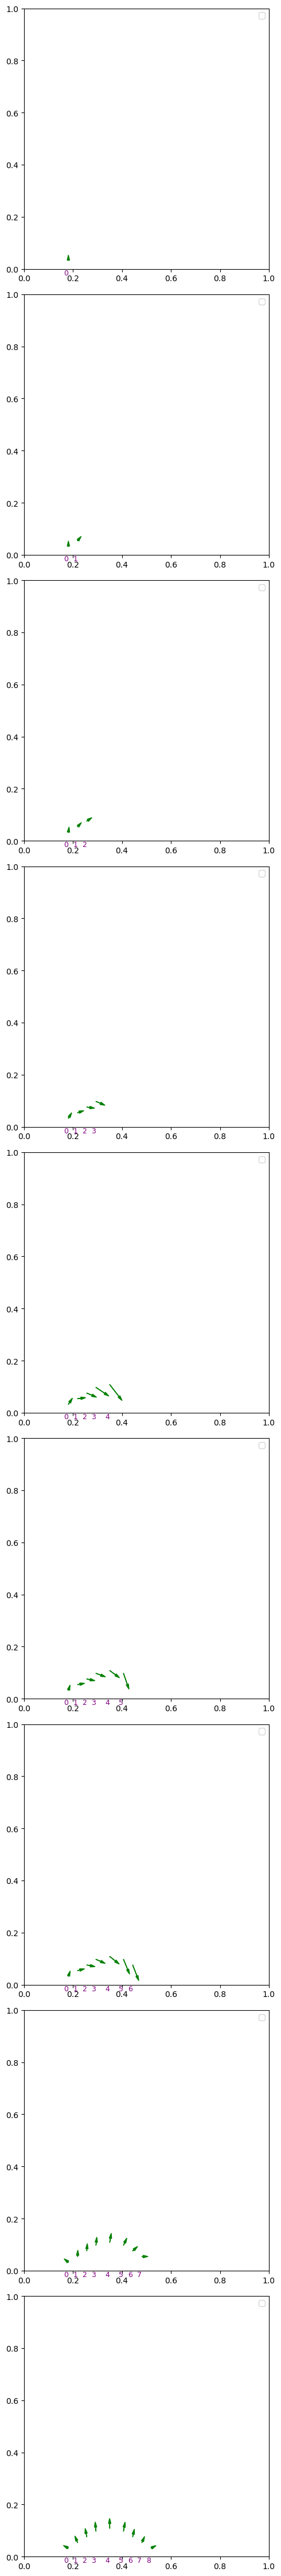

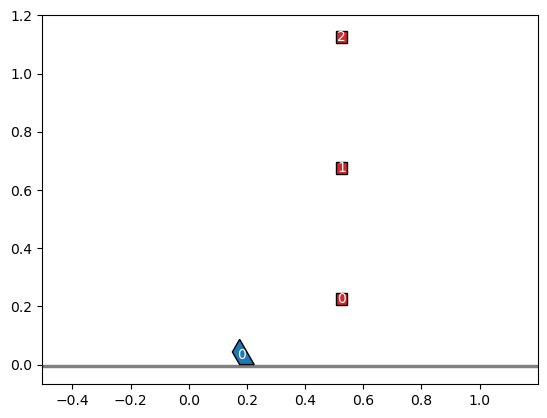

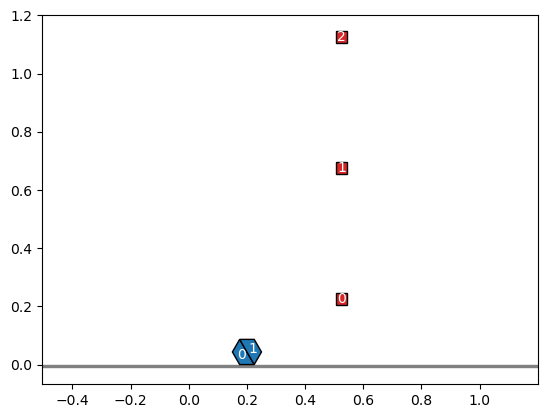

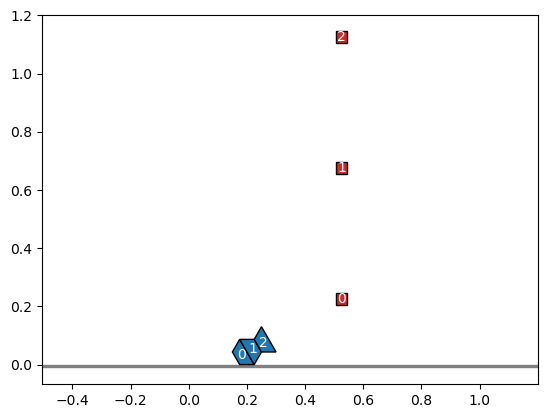

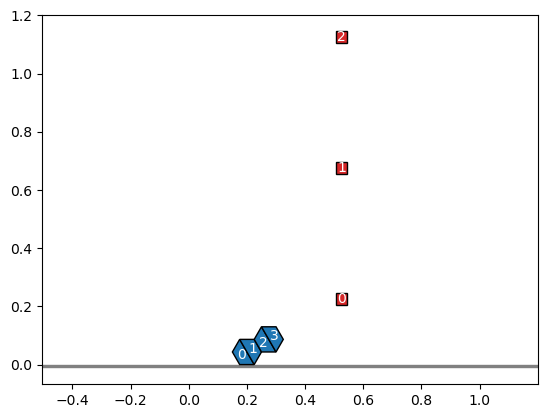

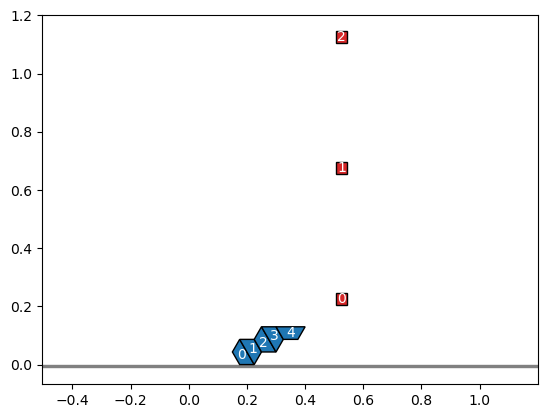

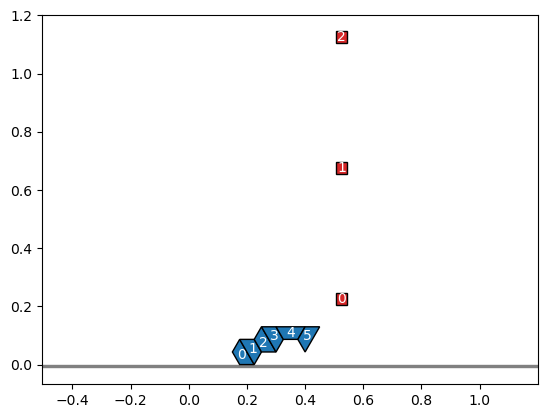

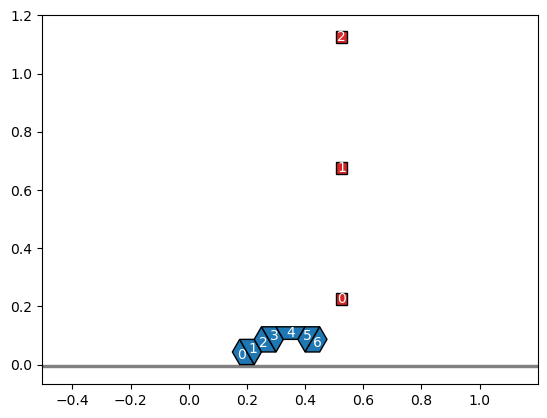

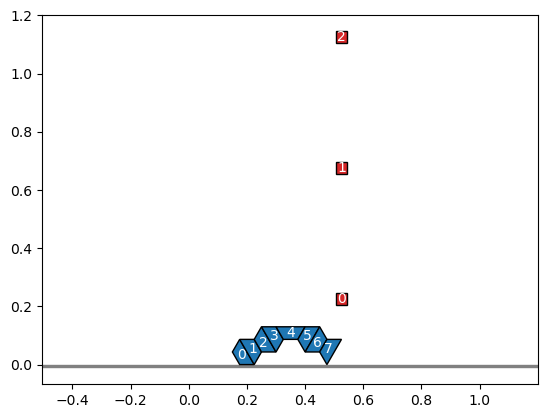

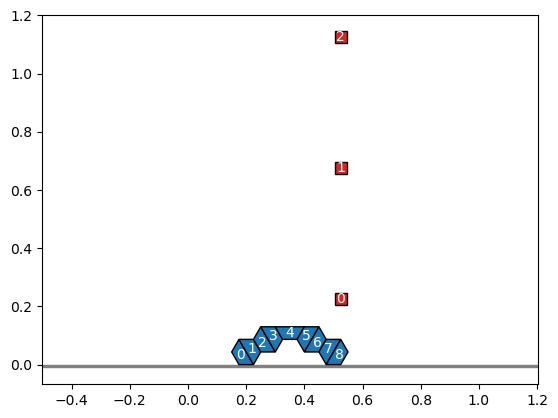

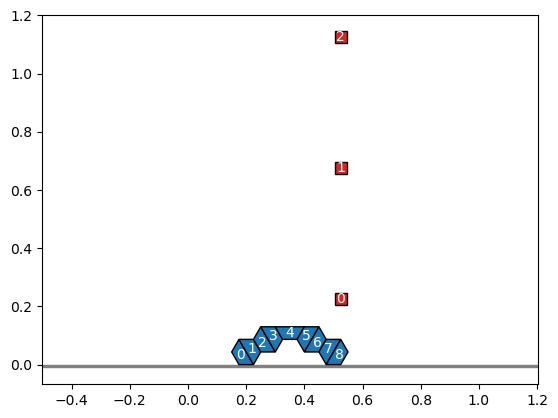

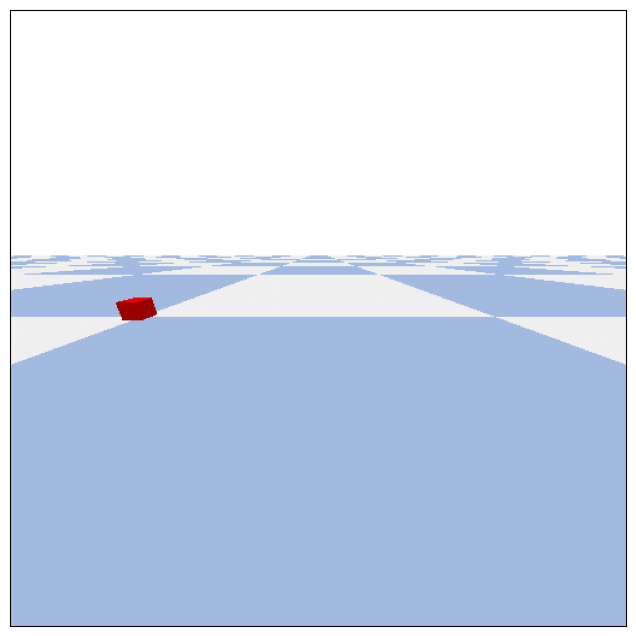

In [17]:
def print_step_info(obs, reward, terminated, truncated, info):
    # Print stable, frozen, collision, and targets reached in one line
    print(f"Stable: {obs['stable']}, Frozen Block: {obs['frozen_block']}, Collision: {obs['collision']}, Targets Reached: {len(obs['targets_reached'])}")
    
    # Print reward and termination in the next lines
    print(f"Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}")
    print("--------------------------------------------------")

env.reset()

fig, axes = plt.subplots(9,1,  figsize=(5, 9*5))

actions = [
    Action(target_block=-1, target_face=0, shape=0, face=0, offset_x=0.2, offset_y=0),
    Action(target_block=0, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=1, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=2, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=3, target_face=1, shape=0, face=2, offset_x=0, offset_y=0),
    Action(target_block=4, target_face=0, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=5, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
    Action(target_block=6, target_face=1, shape=0, face=1, offset_x=0, offset_y=0),
    Action(target_block=7, target_face=3, shape=0, face=3, offset_x=0, offset_y=0),
]

fig.tight_layout()

for action, axis in zip(actions, axes.T):
    obs, reward, terminated, trunated, info = env.step(action)
    plot_assembly_env(env.assembly_env)
    plot_block_movements(info["blocks_initial_state"], info["blocks_final_state"], env.assembly_env.bounds, fig=fig, ax=axis)
    print_step_info(obs, reward, terminated, trunated, info)

fig.subplots_adjust()

plot_assembly_env(env.assembly_env)

env.assembly_env.simulate()
render_assembly_env(target=(0.5, 0, 0), pitch=-20)
env.assembly_env.reset()

## Hard Tower Setup

argv[0]=


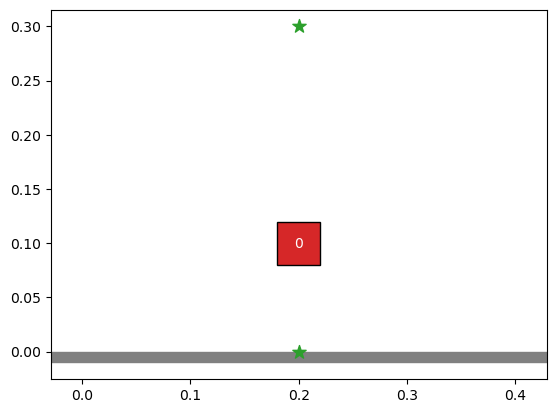

In [18]:
# create a new environment
env = AssemblyGym(**hard_tower_setup(),
                  reward_fct=sparse_reward,
                  restrict_2d=True, 
                  assembly_env=AssemblyEnv(render=False))
plot_assembly_env(env)
env.assembly_env.client.resetDebugVisualizerCamera(cameraDistance=0.5, cameraYaw=0, cameraPitch=-40, cameraTargetPosition=[0.2,0,0])

({'blocks': [Block (2)], 'stable': 1, 'collision': 0, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': -1, 'obstacles': [[0.2, 0, 0.1]], 'obstacle_blocks': [Block (1)], 'targets': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_remaining': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_reached': [], 'distance_to_targets': [0.0, 0.24999999925494193]}, -1, False, None, {'blocks_initial_state': [((0.2, 0.0, 0.02500000037252903), Quaternion(0.707, 0.000, -0.707, 0.000))], 'blocks_final_state': [((0.20000000000012466, -1.3574145397137532e-16, 0.025989997957073033), Quaternion(0.707, -0.000, -0.707, 0.000))]})


(<Figure size 640x480 with 1 Axes>, <Axes: >)

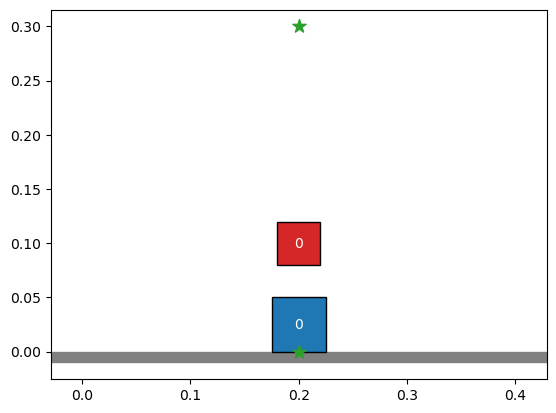

In [19]:
action = Action(-1, 0, 1, 0, 0.2, 0)

print(env.step(action))
plot_assembly_env(env)



({'blocks': [Block (3), Block (2)], 'stable': 1, 'collision': 0, 'collision_block': False, 'collision_obstacle': False, 'collision_floor': False, 'collision_boundary': False, 'frozen_block': -1, 'obstacles': [[0.2, 0, 0.1]], 'obstacle_blocks': [Block (1)], 'targets': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_remaining': [[0.2, 0, 0], [0.2, 0, 0.3]], 'targets_reached': [], 'distance_to_targets': [0.0, 0.24999999925494193]}, -1, False, None, {'blocks_initial_state': [((0.2, 0.0, 0.02500000037252903), Quaternion(0.707, 0.000, -0.707, 0.000)), ((0.14, 0.0, 0.02500000037252903), Quaternion(0.707, 0.000, -0.707, 0.000))], 'blocks_final_state': [((0.20000000000012466, -1.3574145397137532e-16, 0.025989997957073033), Quaternion(0.707, -0.000, -0.707, 0.000)), ((0.14000000000002855, -2.8244391061134464e-15, 0.025990000370499988), Quaternion(0.707, 0.000, -0.707, -0.000))]})
({'blocks': [Block (4), Block (2), Block (3)], 'stable': 1, 'collision': 0, 'collision_block': False, 'collision_obstacle': Fa

(<Figure size 640x480 with 1 Axes>, <Axes: >)

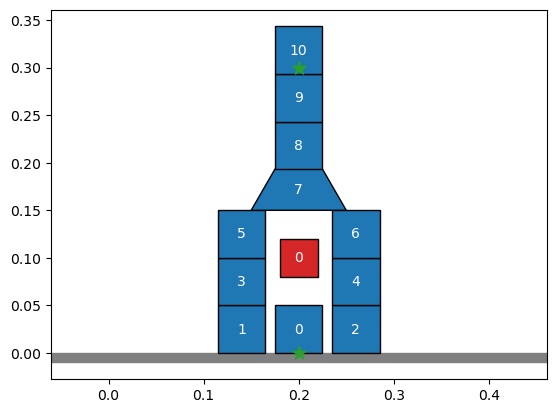

In [20]:
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=0.14, offset_y=0)))
print(env.step(Action(target_block=-1, target_face=0, shape=1, face=0, offset_x=0.26, offset_y=0)))

print(env.step(Action(target_block=1, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=2, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=3, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=4, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))

# trapezoid
print(env.step(Action(target_block=5, target_face=2, shape=0, face=3, offset_x=0.06, offset_y=0)))

print(env.step(Action(target_block=7, target_face=1, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=8, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))
print(env.step(Action(target_block=9, target_face=2, shape=1, face=0, offset_x=0., offset_y=0)))

plot_assembly_env(env)

In [ ]:
env.assembly_env.disconnect_client()